In [ ]:
import torch
import torch.nn as nn
import torchvision.datasets as dataset
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader as DataLoader


In [ ]:
mnist_mean = 0.1307
mnist_std = 0.3081
transformations = transforms.Compose([transforms.ToTensor(),
                                 transforms.Normalize((mnist_mean,),(mnist_std,))])

train_data = dataset.MNIST(root='./data', transform=transformations, train=True,
                                                                  download=True)

test_data = dataset.MNIST(root='./data', transform=transformations, train=False,
                                                                  download=True)



In [ ]:
batch_size = 32
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)


In [ ]:
random_image = train_data[10][0]
plt.imshow(random_image.numpy().reshape(28,28), cmap='gray')

In [ ]:
random_image = train_data[10][0]
random_image = random_image * mnist_std + mnist_mean
plt.imshow(random_image.numpy().reshape(28,28), cmap='gray')

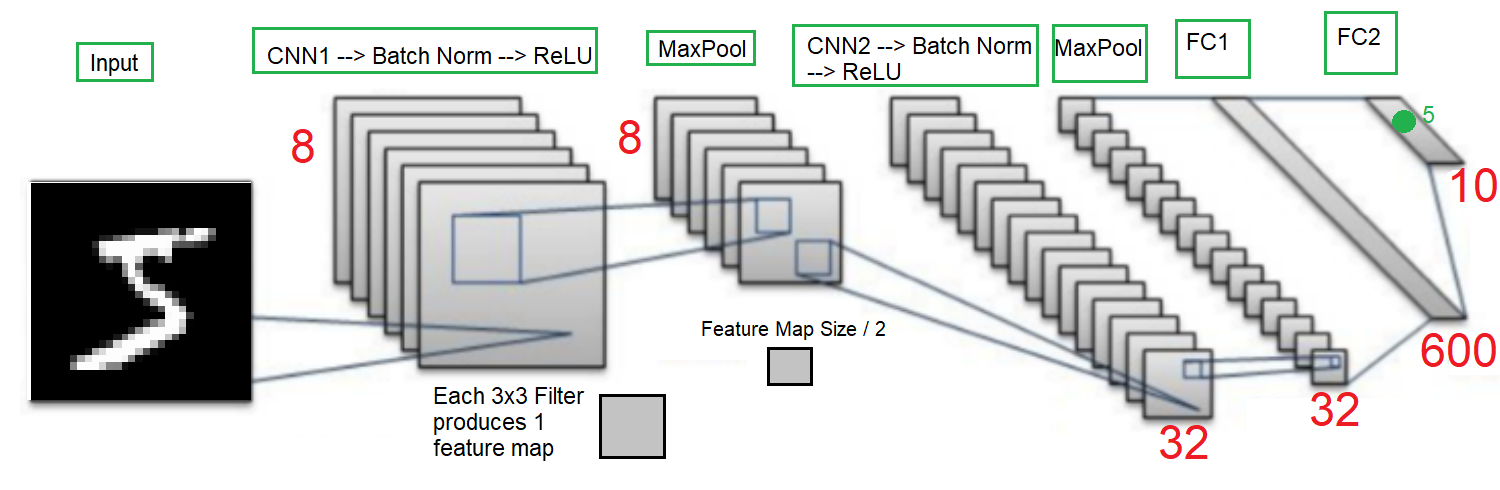

In [ ]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN,self).__init__()
    self.cnn1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1)
    self.batchnorm1 = nn.BatchNorm2d(8)
    self.relu = nn.ReLU()
    self.maxpool = nn.MaxPool2d(kernel_size=2)

    self.cnn2 = nn.Conv2d(in_channels=8, out_channels=32, kernel_size=5, stride=1, padding=2)
    self.batchnorm2 = nn.BatchNorm2d(32)
  

    self.fc1 = nn.Linear(7*7*32, 600)
    self.dropout = nn.Dropout(0.5)
    self.fc2 = nn.Linear(600,10)
  def forward(self,x):
    out = self.cnn1(x)
    out = self.batchnorm1(out)
    out = self.relu(out)
    out = self.maxpool(out)
    out = self.cnn2(out)
    out = self.batchnorm2(out)
    out= self.relu(out)
    out = self.maxpool(out)
    out = out.view(-1, 7*7*32)
    out = self.fc1(out)
    out = self.relu(out)
    out= self.dropout(out)
    out= self.fc2(out)
    return out


In [ ]:
model = CNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
num_epochs = 10

CUDA = torch.cuda.is_available()
if CUDA:
  model=model.cuda()



In [ ]:
train_losses=[]
train_accs=[]
test_losses=[]
test_accs=[]
num_epochs=10

for epoch in range(num_epochs):
  running_loss =0.0
  num_correct=0
  model.train()
  for (images, labels) in train_loader:
    if CUDA:
      images=images.cuda()
      labels=labels.cuda()
    outputs = model(images)
    loss = criterion(outputs, labels)
    running_loss += loss.item()
    _, predictions = torch.max(outputs, 1)
    num_correct+= (predictions==labels).sum().item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  train_losses.append(running_loss / len(train_loader))
  train_accs.append(num_correct / len(train_data))

  test_correct= 0
  test_running_loss =0.0
  model.eval()
  for(images, labels) in test_loader:
    if CUDA:
      images=images.cuda()
      labels=labels.cuda()
    with torch.no_grad():
      outputs = model(images)
      loss = criterion(outputs, labels)
      test_running_loss+= loss
      _, predicted = torch.max(outputs, 1)
      test_correct+= (predicted==labels).sum().item()
  test_losses.append(test_running_loss / len(test_loader))
  test_accs.append(test_correct / len(test_data))

  print('Epoch {}/{}, train loss = {:.3f}, train acc ={:.3f}, test loss ={:.3f}, test acc ={:.3f}'.format(
      epoch+1, num_epochs, train_losses[-1], train_accs[-1], test_losses[-1], test_accs[-1]
  ))

    

    

In [ ]:
import matplotlib.pyplot as plt
f = plt.figure(figsize=(5,5))
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label = 'test loss')
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
f = plt.figure(figsize=(5,5))
plt.plot(train_accs, label='training acc')
plt.plot(test_accs, label = 'test acc')
plt.legend()
plt.show()

In [ ]:
for (name, param) in model.named_parameters():
  print(name, param.shape)